In [1]:
import pandas as pd
import warnings
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

conn = sqlite3.connect('Chinook_analytical.db')

In [2]:
pd.read_sql_query("SELECT name FROM sqlite_master",conn)

,name
0,fact_sales
1,dim_tracks
2,dim_customers


In [5]:
sales = pd.read_sql_query("""SELECT
  strftime('%Y-%m', invoice_date) AS SalesMonth,
  SUM(total_sale) AS MonthlyRevenue,
  SUM(quantity) AS TotalTracksSold
FROM fact_sales
GROUP BY SalesMonth
ORDER BY SalesMonth""",conn)

In [8]:
total_revenue = sales['MonthlyRevenue'].sum()
print(f"Total Revenue to Date: ${total_revenue:,.2f}")

Total Revenue to Date: $2,328.60


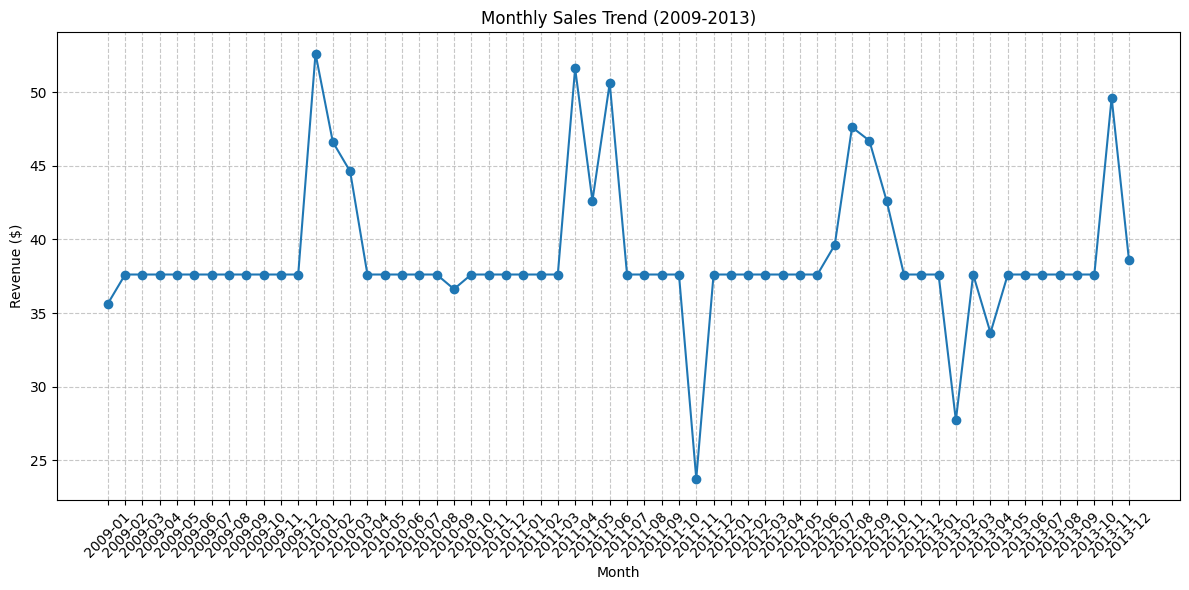

In [7]:
# Plot the trend
plt.figure(figsize=(12, 6))
plt.plot(sales['SalesMonth'], sales['MonthlyRevenue'], marker='o', linestyle='-')
plt.title('Monthly Sales Trend (2009-2013)')
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
top_customers_query = """
SELECT
    c.customer_name,
    c.country,
    SUM(fs.total_sale) AS lifetime_value,
    COUNT(DISTINCT fs.invoice_id) AS number_of_orders
FROM fact_sales fs
JOIN dim_customers c ON fs.customer_id = c.CustomerId
GROUP BY fs.customer_id
ORDER BY lifetime_value DESC
LIMIT 5;
"""

top_customers = pd.read_sql_query(top_customers_query, conn)
top_customers

,customer_name,Country,lifetime_value,number_of_orders
0,Helena Holý,Czech Republic,49.62,7
1,Richard Cunningham,USA,47.62,7
2,Luis Rojas,Chile,46.62,7
3,Hugh O'Reilly,Ireland,45.62,7
4,Ladislav Kovács,Hungary,45.62,7


In [13]:
# Country level statistics
country_potential_query = """
SELECT
    c.country,
    COUNT(DISTINCT fs.customer_id) AS total_customers,
    SUM(fs.total_sale) AS total_revenue,
    SUM(fs.total_sale) / COUNT(DISTINCT fs.customer_id) AS revenue_per_customer,
    MAX(DATE(fs.invoice_date)) AS last_order_date
FROM fact_sales fs
JOIN dim_customers c ON fs.customer_id = c.CustomerId
GROUP BY c.country
ORDER BY total_revenue DESC;
"""

country_stats = pd.read_sql_query(country_potential_query, conn)

country_stats['percent_of_total_revenue'] = (country_stats['total_revenue'] / country_stats['total_revenue'].sum()) * 100
country_stats

,Country,total_customers,total_revenue,revenue_per_customer,last_order_date,percent_of_total_revenue
0,USA,13,523.06,40.235385,2013-12-05,22.462424
1,Canada,8,303.96,37.995000,2013-12-06,13.053337
2,France,5,195.10,39.020000,2013-11-03,8.378425
3,Brazil,5,190.10,38.020000,2013-10-05,8.163704
4,Germany,4,156.48,39.120000,2013-06-03,6.719918
5,United Kingdom,3,112.86,37.620000,2013-08-04,4.846689
6,Czech Republic,2,90.24,45.120000,2013-11-13,3.875290
7,Portugal,2,77.24,38.620000,2013-12-09,3.317015
8,India,2,75.26,37.630000,2013-12-22,3.231985
9,Chile,1,46.62,46.620000,2012-10-14,2.002061


In [14]:
# Top 10 best selling artists
top_artists_query = """
SELECT
    dt.artist_name,
    SUM(fs.quantity) as tracks_sold,
    SUM(fs.total_sale) as revenue_generated
FROM fact_sales fs
JOIN dim_tracks dt ON fs.track_id = dt.TrackId
GROUP BY dt.artist_name
ORDER BY revenue_generated DESC
LIMIT 10;
"""

top_artists = pd.read_sql_query(top_artists_query, conn)
top_artists

,artist_name,tracks_sold,revenue_generated
0,Iron Maiden,140,138.60
1,U2,107,105.93
2,Metallica,91,90.09
3,Led Zeppelin,87,86.13
4,Lost,41,81.59
5,The Office,25,49.75
6,Os Paralamas Do Sucesso,45,44.55
7,Deep Purple,44,43.56
8,Faith No More,42,41.58
9,Eric Clapton,40,39.60


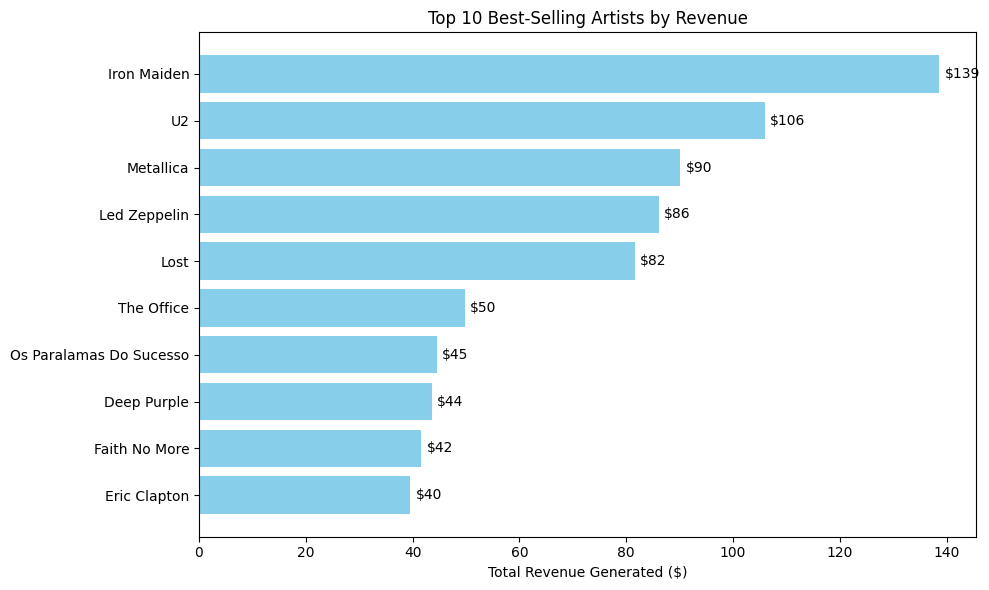

In [18]:
plt.figure(figsize=(10, 6))
# Plot revenue generated
bars = plt.barh(top_artists['artist_name'], top_artists['revenue_generated'], color='skyblue')
plt.xlabel('Total Revenue Generated ($)')
plt.title('Top 10 Best-Selling Artists by Revenue')
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'${width:.0f}', ha='left', va='center')

plt.tight_layout()
plt.show()

In [19]:
# Sales percentage by genre
genre_percentage_query = """
WITH genre_sales AS (
    SELECT
        dt.genre_name,
        SUM(fs.total_sale) AS genre_revenue
    FROM fact_sales fs
    JOIN dim_tracks dt ON fs.track_id = dt.TrackId
    GROUP BY dt.genre_name
)
SELECT
    genre_name,
    genre_revenue,
    ROUND( (genre_revenue / SUM(genre_revenue) OVER () ) * 100, 2) AS percent_of_total_sales
FROM genre_sales
ORDER BY genre_revenue DESC
LIMIT 10;
"""

genre = pd.read_sql_query(genre_percentage_query, conn)
genre

,genre_name,genre_revenue,percent_of_total_sales
0,Rock,826.65,35.50
1,Latin,382.14,16.41
2,Metal,261.36,11.22
3,Alternative & Punk,241.56,10.37
4,TV Shows,93.53,4.02
5,Jazz,79.20,3.40
6,Blues,60.39,2.59
7,Drama,57.71,2.48
8,Classical,40.59,1.74
9,R&B/Soul,40.59,1.74


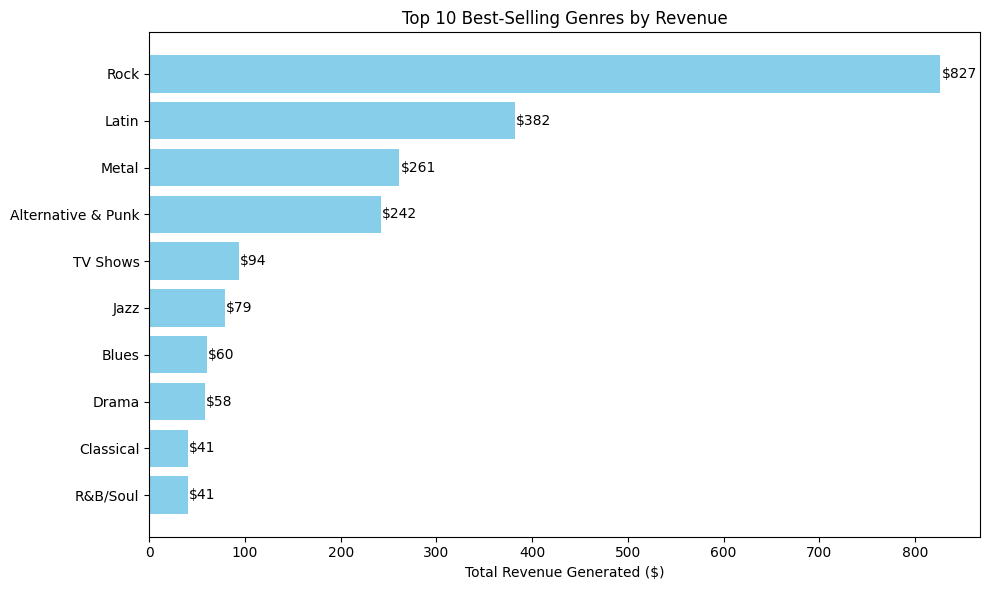

In [22]:
plt.figure(figsize=(10, 6))
# Plot revenue generated
bars = plt.barh(genre['genre_name'], genre['genre_revenue'], color='skyblue')
plt.xlabel('Total Revenue Generated ($)')
plt.title('Top 10 Best-Selling Genres by Revenue')
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'${width:.0f}', ha='left', va='center')

plt.tight_layout()
plt.show()

In [20]:
# Sales performance by support agent
agent_performance_query = """
SELECT
    dc.support_rep_name,
    COUNT(DISTINCT fs.customer_id) AS number_of_customers,
    SUM(fs.total_sale) AS total_sales_supported,
    SUM(fs.total_sale) / COUNT(DISTINCT fs.customer_id) AS avg_sales_per_customer,
    COUNT(DISTINCT fs.invoice_id) AS number_of_invoices
FROM fact_sales fs
JOIN dim_customers dc ON fs.customer_id = dc.CustomerId
WHERE dc.support_rep_name IS NOT NULL 
GROUP BY dc.support_rep_name
ORDER BY total_sales_supported DESC;
"""

agent = pd.read_sql_query(agent_performance_query, conn)
agent

,support_rep_name,number_of_customers,total_sales_supported,avg_sales_per_customer,number_of_invoices
0,Jane Peacock,21,833.04,39.668571,146
1,Margaret Park,20,775.40,38.770000,140
2,Steve Johnson,18,720.16,40.008889,126
